## Loading the data (from 1.0)

In [1]:
from pycocotools.coco import COCO

In [2]:
coco = COCO(annotation_file="/scratch/lt2316-h18-resources/coco/annotations/instances_train2017.json")

loading annotations into memory...
Done (t=19.33s)
creating index...
index created!


In [3]:
cat_cat = coco.getCatIds(catNms="cat")
horse_cat = coco.getCatIds(catNms="horse")

In [4]:
cat_cat, horse_cat

([17], [19])

In [5]:
cat_imgs = coco.getImgIds(catIds=cat_cat)

In [6]:
horse_imgs = coco.getImgIds(catIds=horse_cat)

In [7]:
len(cat_imgs), len(horse_imgs)

(4114, 2941)

In [8]:
import random

In [9]:
random.shuffle(cat_imgs)
cat_imgs_train = cat_imgs[:2000]
cat_imgs_test = cat_imgs[2000:2500]

random.shuffle(horse_imgs)
horse_imgs_train = horse_imgs[:2000]
horse_imgs_test = horse_imgs[2000:2500]

In [10]:
len(cat_imgs_train), len(cat_imgs_test)

(2000, 500)

In [11]:
len([x for x in cat_imgs[0:600] if x in horse_imgs[0:600]])

0

In [12]:
cat_meta_train = coco.loadImgs(ids=cat_imgs_train)

In [13]:
cat_meta_test = coco.loadImgs(ids=cat_imgs_test)
horse_meta_train = coco.loadImgs(ids=horse_imgs_train)
horse_meta_test = coco.loadImgs(ids=horse_imgs_test)

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [15]:
%matplotlib inline

In [16]:
from PIL import Image

In [17]:
import numpy as np

In [18]:
def get_data(meta, datadir="/scratch/lt2316-h18-resources/coco/train2017"):
    return [(x['file_name'], Image.open("{}/{}".format(datadir, x['file_name'])).resize((100,100))) for x in meta]

In [19]:
cat_data_train = get_data(cat_meta_train)

In [20]:
len(cat_data_train)

2000

In [21]:
horse_data_train = get_data(horse_meta_train)
cat_data_test = get_data(cat_meta_test)
horse_data_test = get_data(horse_meta_test)

In [22]:
import pandas as pd

In [23]:
cat_data_train_df = pd.DataFrame(cat_data_train)

In [24]:
cat_data_train_df['class'] = 'cat'

In [25]:
horse_data_train_df = pd.DataFrame(horse_data_train)
horse_data_train_df['class'] = 'horse'

cat_data_test_df = pd.DataFrame(cat_data_test)
cat_data_test_df['class'] = 'cat'

horse_data_test_df = pd.DataFrame(horse_data_test)
horse_data_test_df['class'] = 'horse'

In [26]:
train_df = pd.concat([cat_data_train_df, horse_data_train_df])
test_df = pd.concat([cat_data_test_df, horse_data_test_df])

In [27]:
train_y = [1 if x == 'cat' else 0 for x in train_df['class']]

In [28]:
test_y = [1 if x == 'cat' else 0 for x in test_df['class']]

In [29]:
train_df['imgs'] = train_df[1].apply(lambda x: x.convert('RGB'))

In [30]:
train_X = np.array([np.array(x) for x in train_df['imgs']])

In [31]:
train_X.shape

(4000, 100, 100, 3)

In [32]:
test_df['imgs'] = test_df[1].apply(lambda x: x.convert('RGB'))

In [33]:
test_X = np.array([np.array(x) for x in test_df['imgs']])

In [34]:
test_X.shape

(1000, 100, 100, 3)

## Scale and standardize the data

In [35]:
from sklearn.preprocessing import StandardScaler

In [36]:
all_X = np.concatenate((train_X, test_X))

In [37]:
all_X.shape

(5000, 100, 100, 3)

In [38]:
all_X_scaled = StandardScaler().fit_transform(all_X.reshape(5000,30000)).reshape(5000, 100, 100, 3)

In [39]:
all_X_scaled.shape

(5000, 100, 100, 3)

In [40]:
all_X_scaled

array([[[[-1.53071580e+00, -1.48197237e+00, -1.31594741e+00],
         [-1.52734720e+00, -1.47754608e+00, -1.30843008e+00],
         [-1.53346737e+00, -1.48045085e+00, -1.30895084e+00],
         ...,
         [-1.64006438e+00, -1.61437726e+00, -1.41793200e+00],
         [-1.62314447e+00, -1.59966330e+00, -1.39517811e+00],
         [-1.60843632e+00, -1.58673268e+00, -1.38579320e+00]],

        [[-1.42329286e+00, -1.37419161e+00, -1.23792854e+00],
         [-1.35556621e+00, -1.30743123e+00, -1.15954058e+00],
         [-1.34781516e+00, -1.28466572e+00, -1.11189154e+00],
         ...,
         [-3.79718778e-01, -3.73859694e-01,  2.35823395e-02],
         [-3.91786444e-01, -3.87279530e-01,  8.25906436e-03],
         [-3.56978798e-01, -3.54472817e-01,  1.45997870e-01]],

        [[-1.33440968e+00, -1.27138775e+00, -1.21163754e+00],
         [-1.26520849e+00, -1.20384824e+00, -1.09718552e+00],
         [-1.24337355e+00, -1.19470626e+00, -1.06248168e+00],
         ...,
         [ 1.51644235e+0

In [41]:
train_X = all_X_scaled[:4000]
test_X = all_X_scaled[4000:]
train_X.shape, test_X.shape

((4000, 100, 100, 3), (1000, 100, 100, 3))

In [42]:
import torch

In [43]:
device = torch.device("cuda:2")

In [44]:
train_X_tensor = torch.Tensor(train_X)

In [45]:
train_X_gpu = train_X_tensor.to(device)

In [46]:
test_X_tensor = torch.Tensor(test_X)

In [47]:
test_X_gpu = test_X_tensor.to(device)

In [48]:
train_y_gpu = torch.Tensor(train_y).to(device)

In [49]:
test_y_gpu = torch.Tensor(test_y).to(device)

In [50]:
train_X_tensor.size()

torch.Size([4000, 100, 100, 3])

## Writing our own batching and shuffling (from 1.1)

In [51]:
class Batcher:
    def __init__(self, X, y, device, batch_size=50, max_iter=None):
        self.X = X
        self.y = y
        self.device = device
        self.batch_size=batch_size
        self.max_iter = max_iter
        self.curr_iter = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.curr_iter == self.max_iter:
            raise StopIteration
        permutation = torch.randperm(self.X.size()[0], device=self.device)
        permX = self.X[permutation]
        permy = self.y[permutation]
        splitX = torch.split(permX, self.batch_size)
        splity = torch.split(permy, self.batch_size)
        
        self.curr_iter += 1
        return zip(splitX, splity)

## Making a convolutional neural network

In [52]:
import torch.nn as nn

In [53]:
c1 = nn.Conv2d(3, 3, 3, padding=1)
c1 = c1.to(device)
b1 = nn.BatchNorm2d(3).to(device)
m1 = nn.MaxPool2d(2,2)
m1 = m1.to(device)
tanh = nn.Tanh().to(device)

In [54]:
btest = Batcher(train_X_gpu, train_y_gpu, device)
batch = next(next(btest))

In [55]:
batch[0].size()

torch.Size([50, 100, 100, 3])

In [56]:
batch_tensor = batch[0].permute(0, 3, 1, 2)

In [57]:
batch_tensor

tensor([[[[ 0.9870,  0.8808,  0.9064,  ..., -1.1774, -1.1488, -1.0936],
          [ 0.9612,  0.8796,  0.8654,  ..., -1.2487, -1.3091, -1.2075],
          [ 0.8326,  0.8048,  0.8580,  ..., -1.1762, -1.1613, -1.2166],
          ...,
          [-0.3031, -0.5300, -0.6966,  ..., -1.3960, -1.3570, -1.3367],
          [-0.6325, -0.6833, -0.7134,  ..., -1.2941, -1.2283, -1.3139],
          [-0.7080, -0.7514, -0.7787,  ..., -1.3187, -1.2542, -1.2661]],

         [[ 0.9870,  0.8955,  0.9204,  ..., -1.0421, -1.0292, -1.0017],
          [ 1.0022,  0.9213,  0.8944,  ..., -1.1362, -1.2110, -1.1269],
          [ 0.8764,  0.8359,  0.8621,  ..., -1.1040, -1.0911, -1.1210],
          ...,
          [-0.2107, -0.4551, -0.6393,  ..., -1.2799, -1.2425, -1.2389],
          [-0.5482, -0.6283, -0.6875,  ..., -1.1633, -1.1442, -1.2021],
          [-0.6709, -0.7001, -0.7262,  ..., -1.2096, -1.1574, -1.1709]],

         [[ 1.0733,  1.0007,  1.0022,  ..., -1.2856, -1.2151, -1.2292],
          [ 1.0768,  1.0145,  

In [58]:
batch_tensor.size()

torch.Size([50, 3, 100, 100])

In [59]:
step = c1(batch_tensor)

In [60]:
step.size()

torch.Size([50, 3, 100, 100])

In [61]:
step = b1(step)

In [62]:
step.size()

torch.Size([50, 3, 100, 100])

In [63]:
step = m1(step)

In [64]:
step.size()

torch.Size([50, 3, 50, 50])

In [65]:
relu = nn.ReLU().to(device)
step = relu(step)
step.size()

torch.Size([50, 3, 50, 50])

In [66]:
linear = nn.Linear(3*50*50, 3*50*25).to(device)

In [67]:
step = linear(step.reshape(-1, 3*50*50))

In [68]:
step.size()

torch.Size([50, 3750])

In [69]:
linear = nn.Linear(3*50*25, 1).to(device)

In [70]:
step = linear(step)

In [71]:
step.size()

torch.Size([50, 1])

In [72]:
step

tensor([[ 0.0993],
        [ 0.3158],
        [-0.2331],
        [-0.1187],
        [ 0.0733],
        [-0.3529],
        [-0.1686],
        [ 0.0126],
        [-0.1634],
        [-0.1429],
        [ 0.0421],
        [ 0.1278],
        [ 0.0663],
        [-0.4694],
        [ 0.1341],
        [-0.0188],
        [ 0.0374],
        [ 0.1184],
        [-0.1668],
        [-0.0021],
        [-0.0575],
        [ 0.1249],
        [-0.1438],
        [-0.3224],
        [-0.1950],
        [-0.1240],
        [-0.1900],
        [ 0.1432],
        [-0.0199],
        [ 0.1797],
        [-0.0290],
        [-0.0983],
        [-0.0415],
        [-0.2103],
        [-0.0166],
        [ 0.0066],
        [ 0.3131],
        [ 0.0418],
        [-0.2619],
        [-0.0921],
        [ 0.0925],
        [-0.2883],
        [-0.0672],
        [ 0.0937],
        [ 0.1113],
        [-0.1353],
        [-0.0904],
        [-0.0325],
        [ 0.2631],
        [-0.0223]], device='cuda:2', grad_fn=<AddmmBackward0>)

In [77]:
class CatHorseClassifier(nn.Module):
    def __init__(self, hidden_size, height, width):
        super(CatHorseClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.device = device
        self.height = height
        self.width = width
        
        self.layers1 = nn.Sequential(
            nn.Conv2d(3, 3, 3, padding=1), # three input channels, three output channels, 3x3 window
            nn.BatchNorm2d(3),
#            nn.ReLU(),
#            nn.MaxPool2d(2, 2), # 2x2 window with stride of 2
            nn.Tanh()
        )
        
        self.layers2 = nn.Sequential(
            nn.Linear(self.height * self.width * 3, hidden_size),
            nn.Dropout(0.05),
            nn.Tanh(),
            nn.Linear(hidden_size, int(hidden_size/2)),
            nn.Tanh(),
            nn.Linear(int(hidden_size/2), 1),
            nn.Sigmoid()
        )
        
    def forward(self, batch):
        # permute the channels to the form pytorch expects
        current_matrix = batch.permute(0, 3, 1, 2)
        current_matrix = self.layers1(current_matrix)
        
        return self.layers2(current_matrix.reshape(-1, self.height * self.width * 3))

In [78]:
import torch.optim as optim

In [79]:
def train(X, y, batch_size, epochs, device, model=None):
    b = Batcher(X, y, device, batch_size=batch_size, max_iter=epochs)
    if not model:
        m = CatHorseClassifier(3000, X[0].size()[0], X[0].size()[1]).to(device)
    else:
        m = model
    loss = nn.BCELoss()
    optimizer = optim.Adam(m.parameters(), lr=0.005)
    epoch = 0
    for split in b:
        tot_loss = 0
        for batch in split:
            optimizer.zero_grad()
            o = m(batch[0])
            l = loss(o.reshape(batch_size), batch[1])
            tot_loss += l
            l.backward()
            optimizer.step()
        print("Total loss in epoch {} is {}.".format(epoch, tot_loss))
        epoch += 1
    return m

In [80]:
model = train(train_X_gpu, train_y_gpu, 25, 10, device)

Total loss in epoch 0 is 185.0245361328125.
Total loss in epoch 1 is 124.87016296386719.
Total loss in epoch 2 is 120.38043975830078.
Total loss in epoch 3 is 124.2259750366211.
Total loss in epoch 4 is 110.02668762207031.
Total loss in epoch 5 is 111.00546264648438.
Total loss in epoch 6 is 110.32947540283203.
Total loss in epoch 7 is 109.5352783203125.
Total loss in epoch 8 is 111.5747299194336.
Total loss in epoch 9 is 113.4286117553711.


In [81]:
model = train(train_X_gpu, train_y_gpu, 25, 10, device, model)

Total loss in epoch 0 is 110.5542984008789.
Total loss in epoch 1 is 114.03263854980469.
Total loss in epoch 2 is 109.6899642944336.
Total loss in epoch 3 is 115.2902603149414.
Total loss in epoch 4 is 116.65879821777344.
Total loss in epoch 5 is 118.53431701660156.
Total loss in epoch 6 is 118.67713928222656.
Total loss in epoch 7 is 107.53248596191406.
Total loss in epoch 8 is 102.43370819091797.
Total loss in epoch 9 is 110.40789031982422.


In [82]:
list(model.parameters())

[Parameter containing:
 tensor([[[[-0.0664, -0.1320,  0.0700],
           [ 0.1723,  0.0270,  0.1484],
           [-0.0311,  0.0994,  0.1510]],
 
          [[-0.1203, -0.2346, -0.2160],
           [-0.2499, -0.2243, -0.3014],
           [-0.0375, -0.0268, -0.2248]],
 
          [[-0.2535, -0.5272, -0.3413],
           [-0.3279, -0.3519, -0.2425],
           [-0.5593, -0.3978, -0.4385]]],
 
 
         [[[-0.0608, -0.3885, -0.2212],
           [-0.1561, -0.3114, -0.2126],
           [-0.1066,  0.0226, -0.0233]],
 
          [[ 0.0703,  0.3397,  0.4111],
           [ 0.2880,  0.1533,  0.5132],
           [ 0.2556,  0.5250,  0.4146]],
 
          [[ 0.0666, -0.1127,  0.3000],
           [-0.1358,  0.1485,  0.2520],
           [-0.0350,  0.1575,  0.0848]]],
 
 
         [[[-0.1359,  0.0929, -0.1218],
           [ 0.1174, -0.0930,  0.0051],
           [ 0.0257, -0.1088,  0.0139]],
 
          [[-0.5273, -0.4547, -0.3145],
           [-0.6116, -0.4915, -0.6004],
           [-0.7295, -0.6520, 

In [83]:
model.eval()

CatHorseClassifier(
  (layers1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
  )
  (layers2): Sequential(
    (0): Linear(in_features=30000, out_features=3000, bias=True)
    (1): Dropout(p=0.05, inplace=False)
    (2): Tanh()
    (3): Linear(in_features=3000, out_features=1500, bias=True)
    (4): Tanh()
    (5): Linear(in_features=1500, out_features=1, bias=True)
    (6): Sigmoid()
  )
)

In [84]:
test_X_gpu.size()

torch.Size([1000, 100, 100, 3])

In [85]:
with torch.no_grad():
    predictions = model(test_X_gpu)

In [86]:
predictions.size()

torch.Size([1000, 1])

In [87]:
predictions = predictions.reshape(1000)

In [88]:
test_y_gpu.size(), predictions.size()

(torch.Size([1000]), torch.Size([1000]))

In [89]:
classes = predictions >= 0.5

In [90]:
classes = classes.float()

In [91]:
tp = sum(classes * test_y_gpu)
fp = sum(classes * (~test_y_gpu.bool()).float())
tn = sum((~classes.bool()).float() * (~test_y_gpu.bool()).float())
fn = sum((~classes.bool()).float() * test_y_gpu)

tp, fp, tn, fn

(tensor(315., device='cuda:2'),
 tensor(174., device='cuda:2'),
 tensor(326., device='cuda:2'),
 tensor(185., device='cuda:2'))

In [92]:
accuracy = (tp + tn) / (tp + fp + tn + fn)
accuracy

tensor(0.6410, device='cuda:2')

In [93]:
recall = tp / (tp + fn)
recall

tensor(0.6300, device='cuda:2')

In [94]:
precision = tp / (tp + fp)
precision

tensor(0.6442, device='cuda:2')

In [95]:
f1 = (2 * recall * precision) / (recall + precision)

In [96]:
f1

tensor(0.6370, device='cuda:2')

## A little plotting

In [97]:
def precision_recall(data, preds, incr=0.1):
    threshold = 0.0
    vals = []
    while threshold < 0.99:
        classes = preds >= threshold
        classes = classes.float()

        tp = sum(classes * data)
        fp = sum(classes * (~data.bool()).float())
        fn = sum((~classes.bool()).float() * data)

        recall = tp / (tp + fn)
        precision = tp / (tp + fp)

        vals.append((float(precision), float(recall)))
        threshold += incr
        
    return list(zip(*vals))

In [98]:
prc = precision_recall(test_y_gpu, predictions, incr=0.05)

In [99]:
prc

[(0.5,
  0.5276595950126648,
  0.553386926651001,
  0.5786864757537842,
  0.5901857018470764,
  0.6045519113540649,
  0.6178736686706543,
  0.6245901584625244,
  0.6373239159584045,
  0.6415094137191772,
  0.6441717743873596,
  0.6561797857284546,
  0.6732673048973083,
  0.6797752976417542,
  0.7013422846794128,
  0.7244094610214233,
  0.727748692035675,
  0.71074378490448,
  0.7361111044883728,
  0.7931034564971924),
 (1.0,
  0.9919999837875366,
  0.9639999866485596,
  0.9340000152587891,
  0.8899999856948853,
  0.8500000238418579,
  0.8019999861717224,
  0.7620000243186951,
  0.7239999771118164,
  0.6800000071525574,
  0.6299999952316284,
  0.5839999914169312,
  0.5440000295639038,
  0.48399999737739563,
  0.4180000126361847,
  0.36800000071525574,
  0.27799999713897705,
  0.1720000058412552,
  0.10599999874830246,
  0.04600000008940697)]

In [100]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Recall')

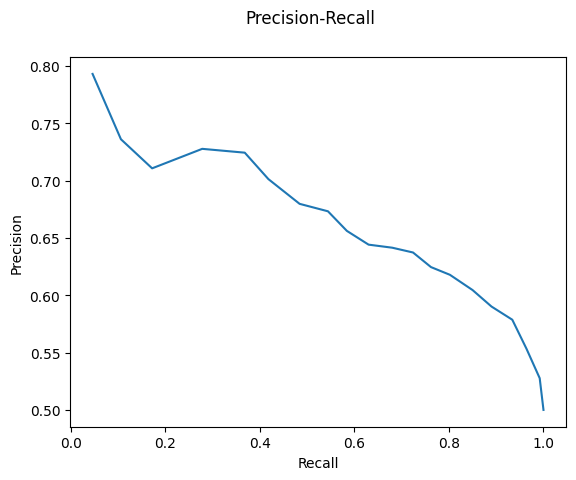

In [101]:
fig = plt.figure()
plt.plot(prc[1], prc[0])
fig.suptitle("Precision-Recall")
plt.ylabel("Precision")
plt.xlabel("Recall")

In [102]:
def roccurve(data, preds, pos_count, incr=0.1):
    threshold = 0.0
    vals = []
    while threshold < 0.99:
        classes = preds >= threshold
        classes = classes.float()

        tp = sum(classes * data)
        fp = sum(classes * (~data.bool()).float())

        vals.append((tp/pos_count, fp/pos_count))
        threshold += incr
        
    return list(zip(*vals))

In [103]:
roc = roccurve(test_y_gpu, predictions, 500, incr=0.05)

In [104]:
roc

[(tensor(1., device='cuda:2'),
  tensor(0.9920, device='cuda:2'),
  tensor(0.9640, device='cuda:2'),
  tensor(0.9340, device='cuda:2'),
  tensor(0.8900, device='cuda:2'),
  tensor(0.8500, device='cuda:2'),
  tensor(0.8020, device='cuda:2'),
  tensor(0.7620, device='cuda:2'),
  tensor(0.7240, device='cuda:2'),
  tensor(0.6800, device='cuda:2'),
  tensor(0.6300, device='cuda:2'),
  tensor(0.5840, device='cuda:2'),
  tensor(0.5440, device='cuda:2'),
  tensor(0.4840, device='cuda:2'),
  tensor(0.4180, device='cuda:2'),
  tensor(0.3680, device='cuda:2'),
  tensor(0.2780, device='cuda:2'),
  tensor(0.1720, device='cuda:2'),
  tensor(0.1060, device='cuda:2'),
  tensor(0.0460, device='cuda:2')),
 (tensor(1., device='cuda:2'),
  tensor(0.8880, device='cuda:2'),
  tensor(0.7780, device='cuda:2'),
  tensor(0.6800, device='cuda:2'),
  tensor(0.6180, device='cuda:2'),
  tensor(0.5560, device='cuda:2'),
  tensor(0.4960, device='cuda:2'),
  tensor(0.4580, device='cuda:2'),
  tensor(0.4120, device='cu

Text(0.5, 0, 'False Positive')

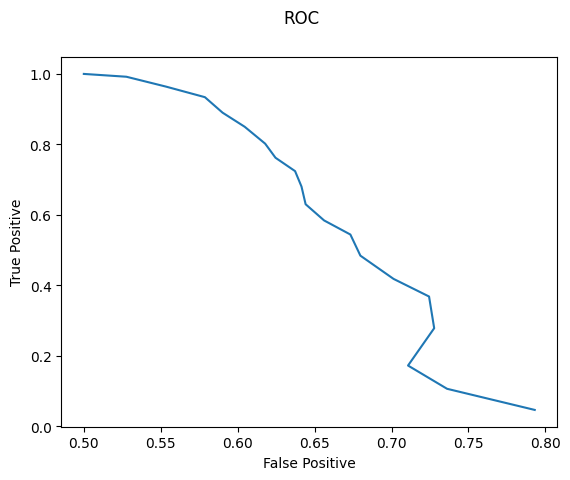

In [105]:
fig = plt.figure()
plt.plot(prc[0], prc[1])
fig.suptitle("ROC")
plt.ylabel("True Positive")
plt.xlabel("False Positive")